In [136]:
import os
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset
from matplotlib import pyplot as plt

class CatOrNotImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        # image = decode_image(img_path)
        image = Image.open(img_path).convert("RGB")  # Use PIL, ensure 3 channels
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [142]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets

from torch.utils.data import DataLoader, ConcatDataset

# batch size
BATCH_SIZE = 64

# the training transforms
train_original = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
    transforms.RandomRotation(degrees=(30, 70)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])

# the validation transforms
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])

In [145]:
import multiprocessing

multiprocessing.cpu_count()

16

In [146]:
training_data_original = CatOrNotImageDataset(
    annotations_file='data/balanced_dataset_output/training_data/annotations.csv',
    img_dir='data/balanced_dataset_output/training_data',
    transform=train_original
)

training_data_augmented = CatOrNotImageDataset(
    annotations_file='data/balanced_dataset_output/training_data/annotations.csv',
    img_dir='data/balanced_dataset_output/training_data',
    transform=train_transform
)

training_data = ConcatDataset([training_data_original, training_data_augmented])

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True, num_workers=8)


test_data = CatOrNotImageDataset(
    annotations_file='data/balanced_dataset_output/test_data/annotations.csv',
    img_dir='data/balanced_dataset_output/test_data',
    transform=test_transform
)

test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True, num_workers=8)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8745098].


Feature batch shape: torch.Size([64, 3, 224, 224])
Labels batch shape: torch.Size([64])


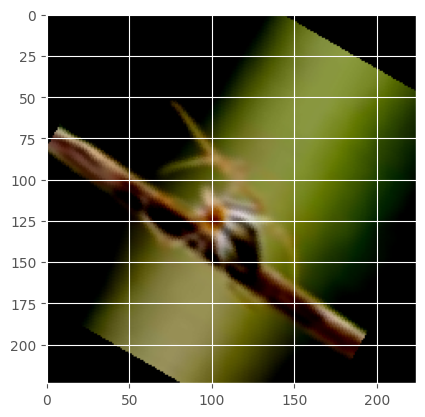

Label: 0


In [147]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0]  # shape: (3, 224, 224)
label = train_labels[0]
# Convert tensor to numpy for display
img_np = img.permute(1, 2, 0).cpu().numpy()  # shape: (224, 224, 3)
plt.imshow(img_np)
plt.show()
print(f"Label: {label}")

In [148]:
import torch.nn as nn
import torch.nn.functional as F

class CatCNNModel(nn.Module):
    def __init__(self):
        super(CatCNNModel, self).__init__()
        # Convolutional Base
        self.conv1 = nn.Conv2d(3, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 3)
        self.conv4 = nn.Conv2d(128, 256, 5)
        self.pool = nn.MaxPool2d(2, 2)
        
        # Classification Head
        # Added dropout for regularization
        self.dropout = nn.Dropout(0.5) 
        
        # Intermediate FC layer
        self.fc1 = nn.Linear(256, 64) 
        
        # Final FC layer: 1 output neuron, no sigmoid here if using BCEWithLogitsLoss
        self.fc_final = nn.Linear(64, 1) 
        
    def forward(self, x):
        # Convolutional layers with pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        
        # Global Average Pooling (GAP)
        bs, _, _, _ = x.shape
        x = F.adaptive_avg_pool2d(x, 1).reshape(bs, -1)
        
        # Fully Connected (Classification) layers
        # Apply ReLU and Dropout after the first FC layer
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        
        # Final output layer
        x = self.fc_final(x) 
        
        return x

In [149]:
import torch
from torch.optim import Adam
from utils import save_model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CatCNNModel().to(device)
optimizer = Adam(model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()
num_epochs = 40

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_idx, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.float().unsqueeze(1).to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        if epoch == 0 and batch_idx == 0:
            print("inputs shape:", inputs.shape)
            print("labels shape:", labels.shape)
    epoch_loss = running_loss / len(train_dataloader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")
    # Save model every 5 epochs (industry standard checkpointing)
    if (epoch + 1) % 5 == 0 or (epoch + 1) == num_epochs:
        save_model(epoch + 1, model, optimizer, criterion)
        print(f"Checkpoint saved at epoch {epoch+1}")

inputs shape: torch.Size([64, 3, 224, 224])
labels shape: torch.Size([64, 1])
Epoch 1/40, Loss: 0.6703
Epoch 2/40, Loss: 0.6529
Epoch 3/40, Loss: 0.6314
Epoch 4/40, Loss: 0.6193
Epoch 5/40, Loss: 0.6032
Checkpoint saved at epoch 5
Epoch 6/40, Loss: 0.6013
Epoch 7/40, Loss: 0.5995
Epoch 8/40, Loss: 0.5793
Epoch 9/40, Loss: 0.5709
Epoch 10/40, Loss: 0.5574
Checkpoint saved at epoch 10
Epoch 11/40, Loss: 0.5536
Epoch 12/40, Loss: 0.5369
Epoch 13/40, Loss: 0.5310
Epoch 14/40, Loss: 0.5215
Epoch 15/40, Loss: 0.5016
Checkpoint saved at epoch 15
Epoch 16/40, Loss: 0.4926
Epoch 17/40, Loss: 0.4868
Epoch 18/40, Loss: 0.4840
Epoch 19/40, Loss: 0.4718
Epoch 20/40, Loss: 0.4595
Checkpoint saved at epoch 20
Epoch 21/40, Loss: 0.4508
Epoch 22/40, Loss: 0.4408
Epoch 23/40, Loss: 0.4303
Epoch 24/40, Loss: 0.4299
Epoch 25/40, Loss: 0.4156
Checkpoint saved at epoch 25
Epoch 26/40, Loss: 0.4278
Epoch 27/40, Loss: 0.3947
Epoch 28/40, Loss: 0.4022
Epoch 29/40, Loss: 0.3776
Epoch 30/40, Loss: 0.3713
Checkpo

Test Accuracy: 0.8353
ROC AUC: 0.9225


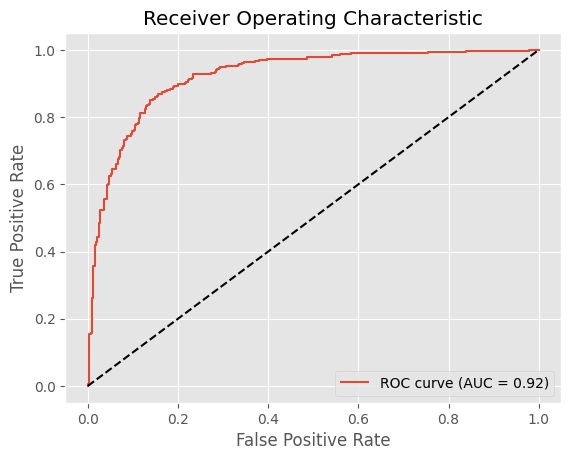

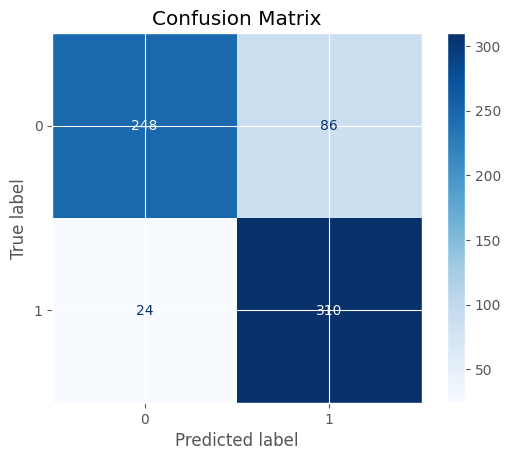

In [150]:
# test the model with robust metrics
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

model.eval()
all_labels = []
all_probs = []
all_preds = []
with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs = inputs.to(device)
        labels = labels.float().unsqueeze(1).to(device)
        outputs = model(inputs)
        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).float()
        all_labels.extend(labels.cpu().numpy().flatten())
        all_probs.extend(probs.cpu().numpy().flatten())
        all_preds.extend(preds.cpu().numpy().flatten())

# Accuracy
accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
print(f"Test Accuracy: {accuracy:.4f}")

# ROC AUC
roc_auc = roc_auc_score(all_labels, all_probs)
print(f"ROC AUC: {roc_auc:.4f}")

# ROC Curve
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [170]:
# test on a custom image
from PIL import Image
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])

def predict_image(image_path, model, transform, device):
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        output = model(image)
        prob = torch.sigmoid(output).item()
        prediction = 1 if prob > 0.8 else 0 if prob < 0.2 else -1
    return prediction, prob
  
image_path = 'data/non-cat/scoiattolo/OIP-_5bWJ7SoPigN4PgV6UozJAHaEo.jpeg'  # replace with your image path
prediction, prob = predict_image(image_path, model, transform, device)

print(f"Prediction: {'Cat' if prediction == 1 else 'Not Cat' if prediction == 0 else 'Uncertain'}, Probability: {prob:.4f}")

Prediction: Uncertain, Probability: 0.3406
